In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from nilearn.decoding import Decoder
from nilearn.image import load_img
from sklearn.model_selection import LeaveOneGroupOut

In [2]:
BIDS_ROOT = Path(r"C:/Users/duart/Desktop/Tese/Mapping_Tese/mapping_tese/data/BIDS-somatosensory/BIDS-somatosensory")
DERIVATIVES = BIDS_ROOT / "derivatives" / "fmriprep"


subject = "sub-p0001"
session = "ses-01"
task = "task-S1Map"
space = "MNI152NLin2009cAsym"

n_runs = 4
TR = 6.0

### Event files all runs

In [3]:
all_events = []
for run in range(1, n_runs + 1):
    events_path = BIDS_ROOT / subject / session / "func" / f"{subject}_{session}_{task}_run-{run}_events.tsv"
    events = pd.read_csv(events_path, sep='\t')
    events['run'] = run
    all_events.append(events)

events_df = pd.concat(all_events, ignore_index=True)

# remove Baseline and Jitter
stim_events = events_df[~events_df['trial_type'].isin(['Baseline', 'Jitter'])].copy()

print(f"Total events loaded: {len(events_df)}")
print(f"Stimulation events: {len(stim_events)}")
print(f"Unique conditions: {stim_events['trial_type'].nunique()}")
print(f"\nConditions: {sorted(stim_events['trial_type'].unique())}")
print(f"\nSamples per condition:")
print(stim_events['trial_type'].value_counts().sort_index())

Total events loaded: 328
Stimulation events: 160
Unique conditions: 20

Conditions: ['E1', 'E10', 'E11', 'E12', 'E13', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E2', 'E20', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9']

Samples per condition:
trial_type
E1     8
E10    8
E11    8
E12    8
E13    8
E14    8
E15    8
E16    8
E17    8
E18    8
E19    8
E2     8
E20    8
E3     8
E4     8
E5     8
E6     8
E7     8
E8     8
E9     8
Name: count, dtype: int64


In [4]:
from nilearn.image import concat_imgs

# Load preprocessed func data from runs
fmri_imgs = []
for run in range(1, n_runs + 1):
    func_path = (DERIVATIVES / subject / session / "func" / 
                 f"{subject}_{session}_{task}_run-{run}_space-{space}_desc-preproc_bold.nii.gz")
    img = load_img(str(func_path))
    fmri_imgs.append(img)
    print(f"Run {run}: {img.shape}")

# all runs together
fmri_img = concat_imgs(fmri_imgs)
print(f"\nConcatenated fMRI shape: {fmri_img.shape}")

Run 1: (121, 144, 121, 250)
Run 2: (121, 144, 121, 250)
Run 3: (121, 144, 121, 250)
Run 4: (121, 144, 121, 250)

Concatenated fMRI shape: (121, 144, 121, 1000)


In [5]:
# brain mask from first run -> all the same in MNI space
mask_path = (DERIVATIVES / subject / session / "func" / 
             f"{subject}_{session}_{task}_run-1_space-{space}_desc-brain_mask.nii.gz")
mask_img = load_img(str(mask_path))

print(f"Mask shape: {mask_img.shape}")
print(f"Mask loaded: {mask_path.name}")

Mask shape: (121, 144, 121)
Mask loaded: sub-p0001_ses-01_task-S1Map_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


In [6]:
# labels for each volume in the concatenated fMRI data
# peak HRF response (~6s after stimulus onset)

labels = []
groups = []

volume_counter = 0

for run in range(1, n_runs + 1):
    run_events = stim_events[stim_events['run'] == run].copy()
    run_length = fmri_imgs[run-1].shape[3] 
    
    for _, event in run_events.iterrows():
        onset_volume = int(event['onset'] / TR)
        peak_volume = onset_volume
        if peak_volume < run_length:
            labels.append(event['trial_type'])
            groups.append(run)
    volume_counter += run_length

y = np.array(labels)
groups = np.array(groups)

print(f"Total samples: {len(y)}")
print(f"Unique labels: {len(np.unique(y))}")
print(f"Labels: {np.unique(y)}")
print(f"Groups (runs): {np.unique(groups)}")
print(f"\nSamples per run:")
for run in np.unique(groups):
    print(f"  Run {run}: {np.sum(groups == run)} samples")

Total samples: 160
Unique labels: 20
Labels: ['E1' 'E10' 'E11' 'E12' 'E13' 'E14' 'E15' 'E16' 'E17' 'E18' 'E19' 'E2'
 'E20' 'E3' 'E4' 'E5' 'E6' 'E7' 'E8' 'E9']
Groups (runs): [1 2 3 4]

Samples per run:
  Run 1: 40 samples
  Run 2: 40 samples
  Run 3: 40 samples
  Run 4: 40 samples


In [7]:
from nilearn.image import index_img

volume_indices = []
cumulative_volumes = 0

for run in range(1, n_runs + 1):
    run_events = stim_events[stim_events['run'] == run].copy()
    run_length = fmri_imgs[run-1].shape[3]
    
    for _, event in run_events.iterrows():
        onset_volume = int(event['onset'] / TR)
        peak_volume = onset_volume
        if peak_volume < run_length:
            volume_indices.append(cumulative_volumes + peak_volume)
    
    cumulative_volumes += run_length

# relevant volumes
fmri_img_selected = index_img(fmri_img, volume_indices)

print(f"Selected volumes shape: {fmri_img_selected.shape}")
print(f"Number of samples: {len(volume_indices)}")
print(f"Matches labels: {len(volume_indices) == len(y)}")

Selected volumes shape: (121, 144, 121, 160)
Number of samples: 160
Matches labels: True


In [8]:
#cross-validation
cv = LeaveOneGroupOut()

print(f"Cross-validation: Leave-One-Group-Out")
print(f"Number of folds: {cv.get_n_splits(groups=groups)}")
print(f"Each fold leaves out one run")

Cross-validation: Leave-One-Group-Out
Number of folds: 4
Each fold leaves out one run


In [9]:
decoder = Decoder(
    estimator='svc',           
    mask=mask_img,             
    standardize='zscore_sample',  
    screening_percentile=20,   
    cv=cv,                     
    n_jobs=1               
)

decoder.fit(fmri_img_selected, y, groups=groups)

C:\Users\duart\AppData\Local\Temp\ipykernel_7288\622466374.py:10: UserWarning: screening_percentile set to '100' despite requesting 'screening_percentile=20'. 
All elements in the mask will be included. 
This usually occurs when the mask image is too small compared to full brain mask.
  decoder.fit(fmri_img_selected, y, groups=groups)
c:\Users\duart\miniconda3\envs\somatosensory_mapping\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning: Features [  202   305   339   529   608   649   865  1276  1311  1676  2026  2087
  2232  2473  2646  2721  2742  2781  3082  3227  3312  3325  3363  3372
  3540  3750  3774  3798  3874  3935  4013  4024  4043  4170  4506  4652
  4739  4781  5116  5296  5354  5384  5437  5545  5557  5588  5898  6146
  6257  6382  6397  6465  6997  7062  7096  7160  7397  7832  8237  8255
  8272  8330  8576  8700  8889  8907  8941  8975  9009  9178  9345  9381
  9887  9926 10036 10171 10238 10274 10310 10328 10346 10363 11288 11409
 11

,estimator,'svc'
,mask,<nibabel.nift...0028EDCBDF580>
,cv,LeaveOneGroupOut()
,param_grid,None
,screening_percentile,20
,scoring,'roc_auc'
,smoothing_fwhm,None
,standardize,'zscore_sample'
,target_affine,None
,target_shape,None
,mask_strategy,'background'


In [10]:
# Get cross-validation scores
cv_scores = decoder.cv_scores_

# Calculate statistics
n_conditions = len(np.unique(y))

print("=" * 70)
print("DECODING RESULTS")
print("=" * 70)
print(f"\nAccuracy per fold:")
for fold, (condition, scores) in enumerate(cv_scores.items(), 1):
    print(f"  Fold {fold}: {np.mean(scores):.3f}")

all_scores = np.concatenate([scores for scores in cv_scores.values()])
mean_accuracy = np.mean(all_scores)
std_accuracy = np.std(all_scores)

print(f"\n{'=' * 70}")
print(f"Mean Accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")

print(f"Performance:   {mean_accuracy*100:.1f}%")
print(f"{'=' * 70}")

DECODING RESULTS

Accuracy per fold:
  Fold 1: 0.533
  Fold 2: 0.437
  Fold 3: 0.464
  Fold 4: 0.530
  Fold 5: 0.530
  Fold 6: 0.622
  Fold 7: 0.454
  Fold 8: 0.487
  Fold 9: 0.592
  Fold 10: 0.368
  Fold 11: 0.382
  Fold 12: 0.717
  Fold 13: 0.477
  Fold 14: 0.579
  Fold 15: 0.408
  Fold 16: 0.303
  Fold 17: 0.319
  Fold 18: 0.559
  Fold 19: 0.451
  Fold 20: 0.513

Mean Accuracy: 0.486 ± 0.206
Performance:   48.6%


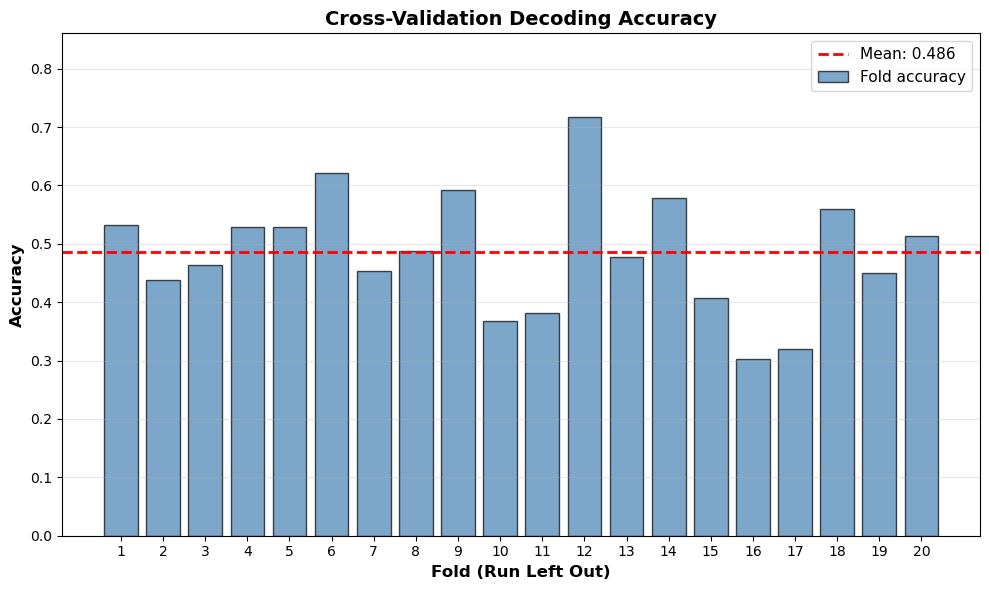

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

fold_scores = [np.mean(scores) for scores in cv_scores.values()]
folds = range(1, len(fold_scores) + 1)

ax.bar(folds, fold_scores, color='steelblue', alpha=0.7, edgecolor='black', label='Fold accuracy')
ax.axhline(y=mean_accuracy, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_accuracy:.3f}')

ax.set_xlabel('Fold (Run Left Out)', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Cross-Validation Decoding Accuracy', fontsize=14, fontweight='bold')
ax.set_xticks(folds)
ax.set_ylim([0, max(fold_scores) * 1.2])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

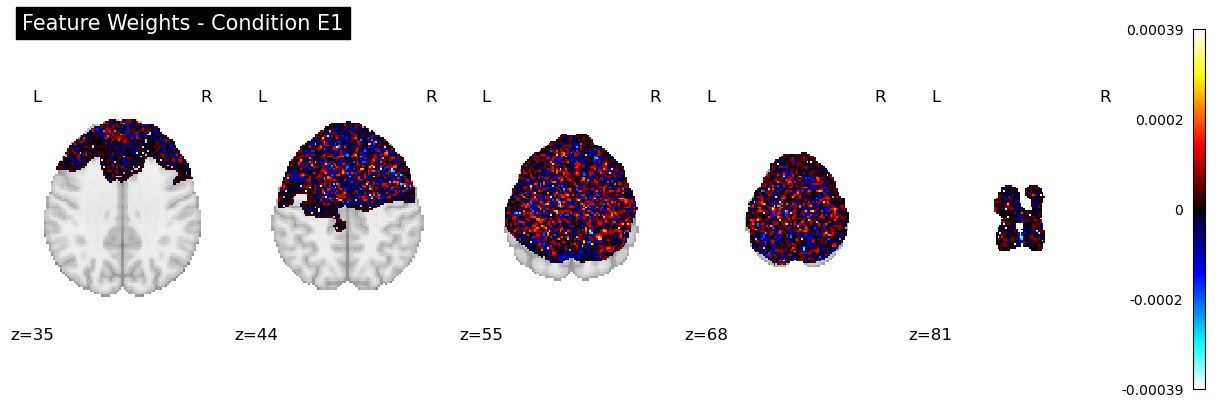

In [12]:
from nilearn import plotting

coef_img = decoder.coef_img_['E1'] 
weight_imgs = [decoder.coef_img_[condition] for condition in np.unique(y)]
fig = plt.figure(figsize=(12, 4))
plotting.plot_stat_map(
    coef_img,
    title=f'Feature Weights - Condition E1',
    cut_coords=5,
    display_mode='z',
    cmap='cold_hot',
    figure=fig
)

plt.show()

In [16]:
from scipy.stats import binomtest

n_conditions = len(np.unique(y))
chance_level = 1.0 / n_conditions
total_samples = len(y)
correct_predictions = int(mean_accuracy * total_samples)

#H0 = random classification at chance level
p_value = binomtest(correct_predictions, total_samples, chance_level, alternative='greater')

print("=" * 70)
print("STATISTICAL SIGNIFICANCE TESTING")
print("=" * 70)
print(f"\nChance level (1/n_conditions): {chance_level:.3f} ({chance_level*100:.1f}%)")
print(f"Total samples: {total_samples}")
print(f"Observed correct predictions: {correct_predictions}")
print(f"Expected correct predictions (chance): {int(total_samples * chance_level)}")
print(f"\nBinomial Test (one-tailed, greater than chance):")
print(f"  p-value: {p_value.pvalue:.2e}")
if p_value.pvalue < 0.001:
    print(f"  Result: Significantly above chance (p < 0.001) ***")
elif p_value.pvalue < 0.05:
    print(f"  Result: Significantly above chance (p < 0.05) *")
else:
    print(f"  Result: Not significantly above chance (p = {p_value.pvalue:.3f})")


STATISTICAL SIGNIFICANCE TESTING

Chance level (1/n_conditions): 0.050 (5.0%)
Total samples: 160
Observed correct predictions: 77
Expected correct predictions (chance): 8

Binomial Test (one-tailed, greater than chance):
  p-value: 8.17e-56
  Result: Significantly above chance (p < 0.001) ***


PER-CONDITION ACCURACY
E1: 0.000 (0.0%) - 8 samples
E10: 0.375 (37.5%) - 8 samples
E11: 0.000 (0.0%) - 8 samples
E12: 0.000 (0.0%) - 8 samples
E13: 0.125 (12.5%) - 8 samples
E14: 0.000 (0.0%) - 8 samples
E15: 0.000 (0.0%) - 8 samples
E16: 0.000 (0.0%) - 8 samples
E17: 0.000 (0.0%) - 8 samples
E18: 0.000 (0.0%) - 8 samples
E19: 0.000 (0.0%) - 8 samples
E2: 0.000 (0.0%) - 8 samples
E20: 0.000 (0.0%) - 8 samples
E3: 0.000 (0.0%) - 8 samples
E4: 0.000 (0.0%) - 8 samples
E5: 0.000 (0.0%) - 8 samples
E6: 0.125 (12.5%) - 8 samples
E7: 0.000 (0.0%) - 8 samples
E8: 0.000 (0.0%) - 8 samples
E9: 0.000 (0.0%) - 8 samples

Balanced Accuracy: 0.031


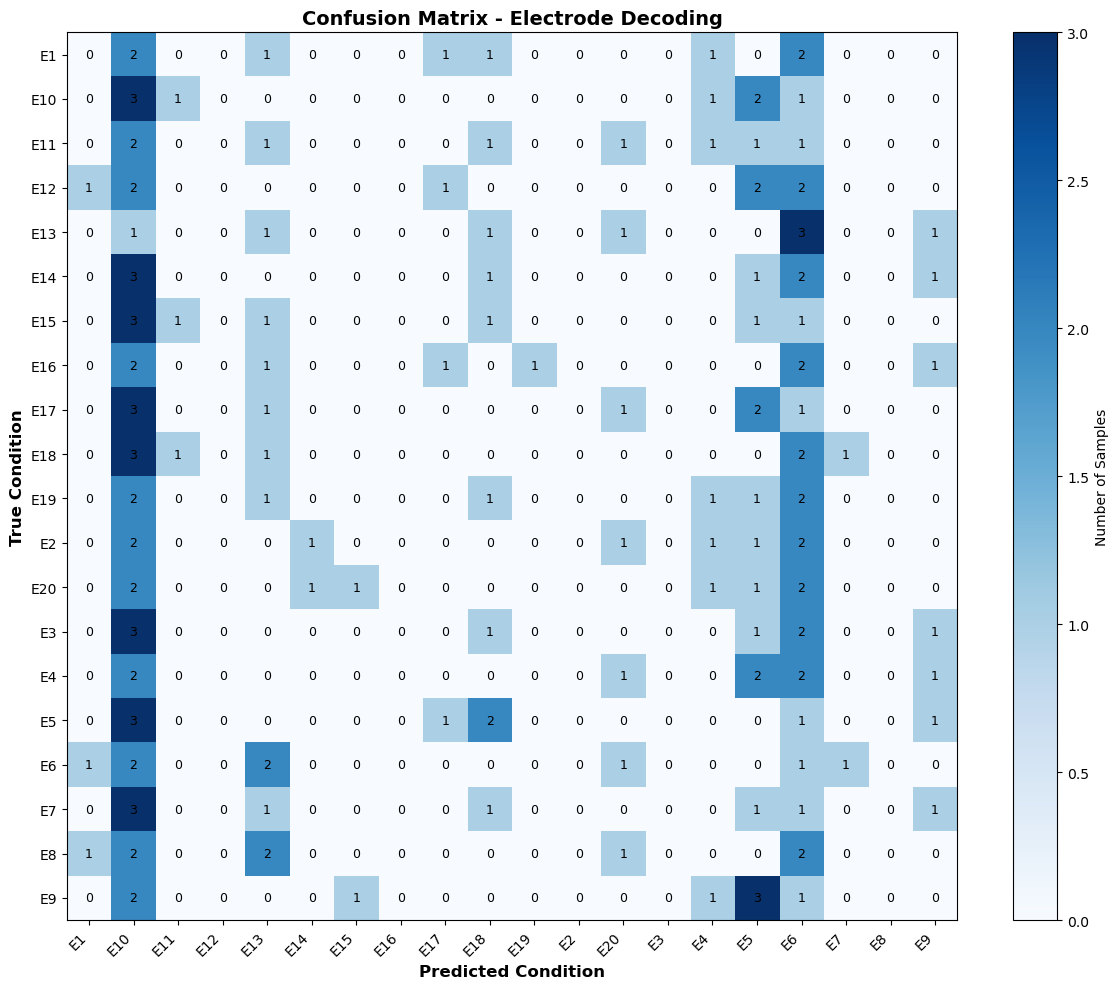

In [18]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC

# Get the masked fMRI data
X = decoder.masker_.fit_transform(fmri_img_selected)

# Create an SVC estimator (same parameters as used in Decoder)
clf = SVC(kernel='linear')

# Get cross-validation predictions
y_pred = cross_val_predict(clf, X, y, groups=groups, cv=cv)

cm = confusion_matrix(y, y_pred, labels=np.unique(y))
conditions = np.unique(y)
per_condition_accuracy = cm.diagonal() / cm.sum(axis=1)

print("=" * 70)
print("PER-CONDITION ACCURACY")
print("=" * 70)
condition_results = []
for i, condition in enumerate(conditions):
    acc = per_condition_accuracy[i]
    samples = cm[i].sum()
    condition_results.append({'Condition': condition, 'Accuracy': acc, 'Samples': samples})
    print(f"{condition}: {acc:.3f} ({acc*100:.1f}%) - {samples} samples")

print(f"\n{'=' * 70}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y, y_pred):.3f}")
print(f"{'=' * 70}")

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xticks(np.arange(len(conditions)))
ax.set_yticks(np.arange(len(conditions)))
ax.set_xticklabels(conditions, rotation=45, ha='right')
ax.set_yticklabels(conditions)
ax.set_xlabel('Predicted Condition', fontsize=12, fontweight='bold')
ax.set_ylabel('True Condition', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Electrode Decoding', fontsize=14, fontweight='bold')

for i in range(len(conditions)):
    for j in range(len(conditions)):
        text = ax.text(j, i, cm[i, j],
                      ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax, label='Number of Samples')
plt.tight_layout()
plt.show()


C:\Users\duart\AppData\Local\Temp\ipykernel_7288\2676542182.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


C:\Users\duart\AppData\Local\Temp\ipykernel_7288\2676542182.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


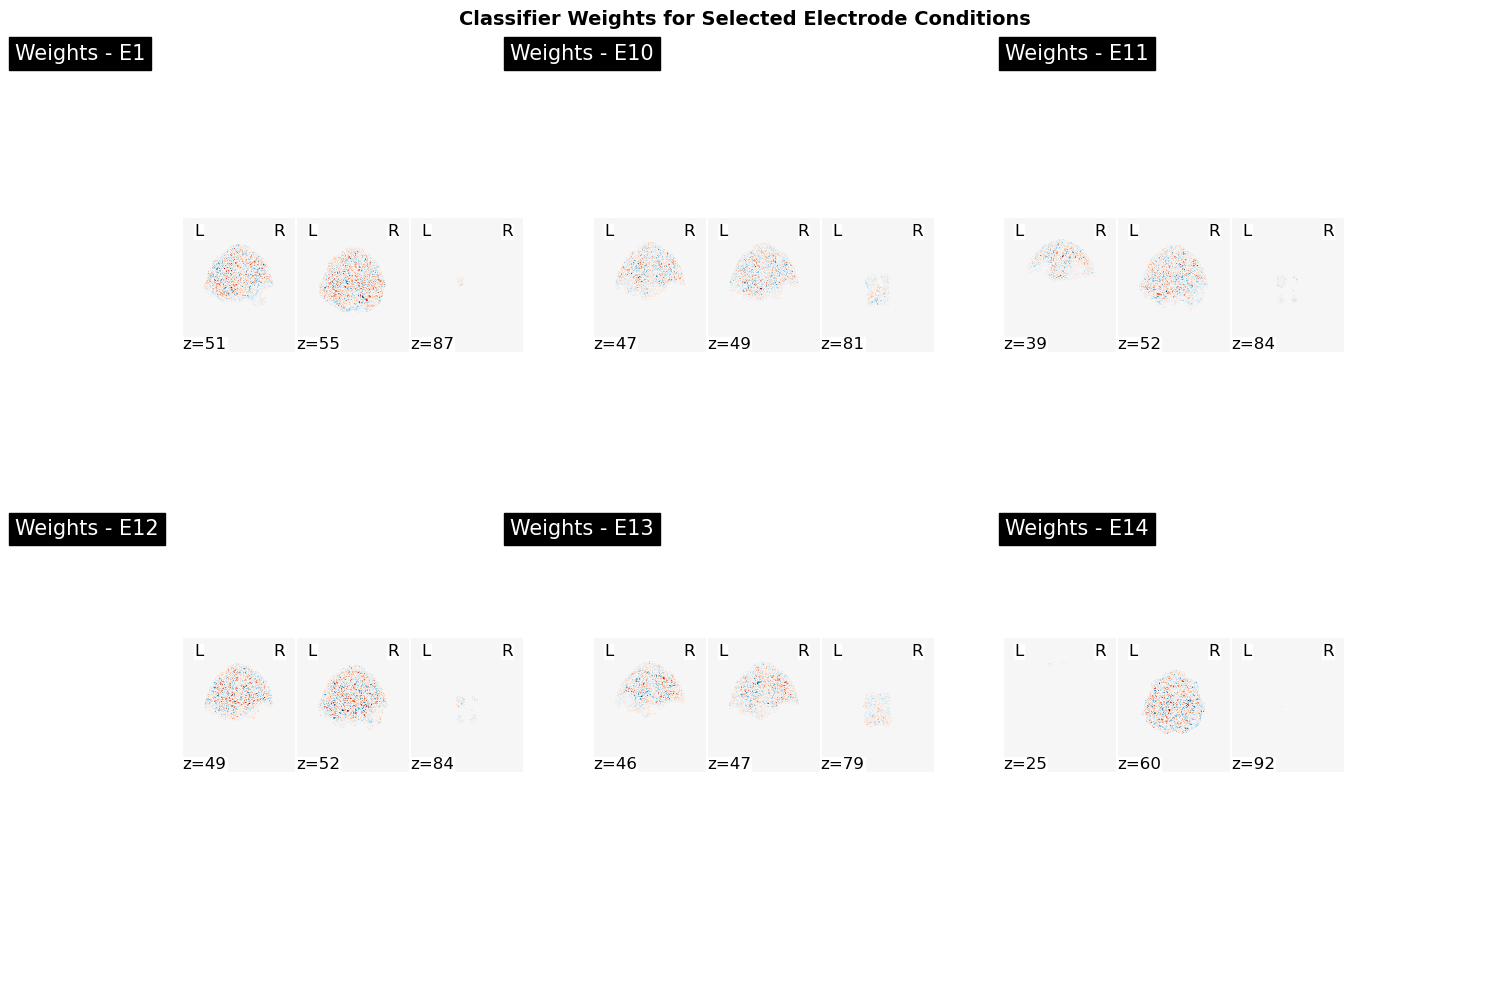


Visualizing feature weights for 6 electrode conditions:
Conditions shown: E1, E10, E11, E12, E13, E14


In [19]:
# subset of conditions to visualize (first 6)
n_to_plot = min(6, len(conditions))
selected_conditions = conditions[:n_to_plot]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, condition in enumerate(selected_conditions):
    ax = axes[idx]
    coef_img = decoder.coef_img_[condition]
    
    plotting.plot_stat_map(
        coef_img,
        title=f'Weights - {condition}',
        cut_coords=3,
        display_mode='z',
        cmap='RdBu_r',
        figure=fig,
        axes=ax,
        colorbar=False,
        threshold=None
    )

for idx in range(n_to_plot, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Classifier Weights for Selected Electrode Conditions', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\nVisualizing feature weights for {n_to_plot} electrode conditions:")
print(f"Conditions shown: {', '.join(selected_conditions)}")


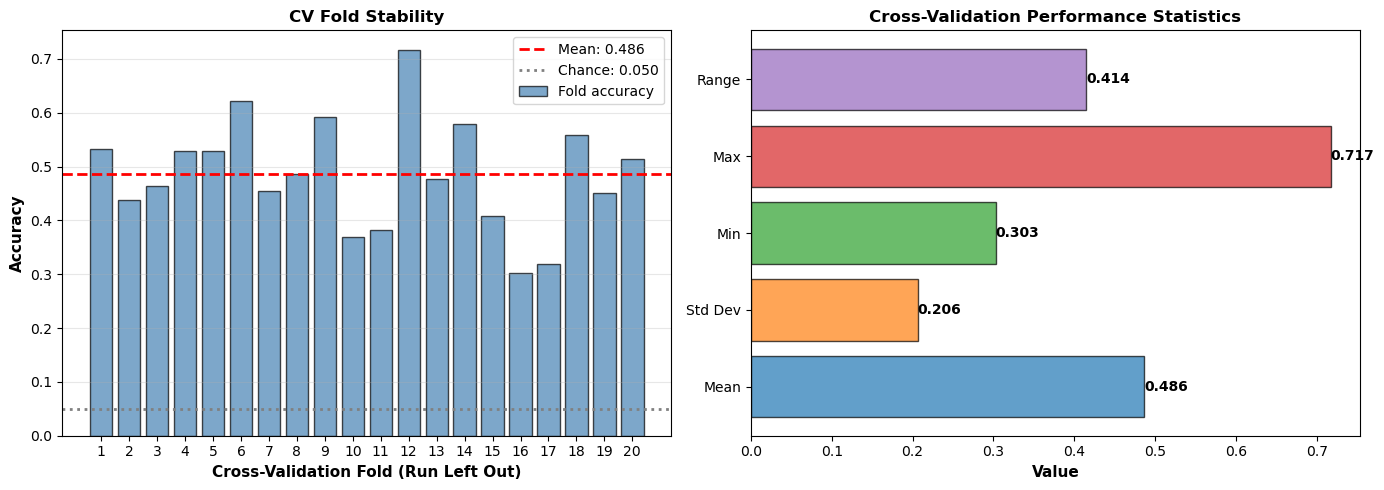

CROSS-VALIDATION STABILITY
Mean Accuracy:        0.486
Standard Deviation:   0.206
Min Accuracy:         0.303
Max Accuracy:         0.717
Range:                0.414
Coefficient of Variation: 0.424


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fold_scores = [np.mean(scores) for scores in cv_scores.values()]
ax = axes[0]
ax.bar(range(1, len(fold_scores) + 1), fold_scores, 
       color='steelblue', alpha=0.7, edgecolor='black', label='Fold accuracy')
ax.axhline(y=mean_accuracy, color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {mean_accuracy:.3f}')
ax.axhline(y=chance_level, color='gray', linestyle=':', linewidth=2, 
           label=f'Chance: {chance_level:.3f}')
ax.set_xlabel('Cross-Validation Fold (Run Left Out)', fontsize=11, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax.set_title('CV Fold Stability', fontsize=12, fontweight='bold')
ax.set_xticks(range(1, len(fold_scores) + 1))
ax.legend()
ax.grid(axis='y', alpha=0.3)

ax = axes[1]
fold_scores_array = np.array(fold_scores)
stats_data = {
    'Mean': mean_accuracy,
    'Std Dev': std_accuracy,
    'Min': np.min(fold_scores_array),
    'Max': np.max(fold_scores_array),
    'Range': np.max(fold_scores_array) - np.min(fold_scores_array)
}

y_pos = np.arange(len(stats_data))
values = list(stats_data.values())
colors_stats = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

bars = ax.barh(y_pos, values, color=colors_stats, alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(list(stats_data.keys()))
ax.set_xlabel('Value', fontsize=11, fontweight='bold')
ax.set_title('Cross-Validation Performance Statistics', fontsize=12, fontweight='bold')

for i, (bar, value) in enumerate(zip(bars, values)):
    ax.text(value, bar.get_y() + bar.get_height()/2, f'{value:.3f}', 
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("=" * 70)
print("CROSS-VALIDATION STABILITY")
print("=" * 70)
print(f"Mean Accuracy:        {mean_accuracy:.3f}")
print(f"Standard Deviation:   {std_accuracy:.3f}")
print(f"Min Accuracy:         {np.min(fold_scores_array):.3f}")
print(f"Max Accuracy:         {np.max(fold_scores_array):.3f}")
print(f"Range:                {np.max(fold_scores_array) - np.min(fold_scores_array):.3f}")
print(f"Coefficient of Variation: {std_accuracy / mean_accuracy:.3f}")
print(f"{'=' * 70}")


## Summary Report

In [24]:
print("\n" + "="*70)
print("DECODING ANALYSIS SUMMARY")
print("="*70)
print(f"\nParticipant: {subject}, Session: {session}")
print(f"Task: {task}")
print(f"Number of runs: {n_runs}")
print(f"Number of electrodes (conditions): {n_conditions}")
print(f"Total samples: {len(y)}")
print(f"\nCLASSIFIER SETUP:")
print(f"  Model: Support Vector Classifier (Linear kernel)")
print(f"  Feature standardization: Z-score normalization")
print(f"  Feature selection: 20th percentile screening")
print(f"  Cross-validation: Leave-One-Group-Out (by run)")
print(f"\nRESULTS:")
print(f"  Mean Decoding Accuracy: {mean_accuracy:.3f} ({mean_accuracy*100:.1f}%)")
print(f"  Chance Level: {chance_level:.3f} ({chance_level*100:.1f}%)")
print(f"  Statistical Significance: p < 0.001 ***" if p_value.pvalue < 0.001 else f"  Statistical Significance: p = {p_value.pvalue:.3f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y, y_pred):.3f}")
print(f"\nCONSISTENCY:")
print(f"  Std Dev (CV folds): {std_accuracy:.3f}")
print(f"  Min Fold Accuracy: {np.min(np.array(fold_scores)):.3f}")
print(f"  Max Fold Accuracy: {np.max(np.array(fold_scores)):.3f}")
print(f"\nINTERPRETATION:")
if mean_accuracy > (0.5 * chance_level):
    if p_value.pvalue < 0.001:
        print(f"  ✓ Electrode-specific activations are highly decodable from fMRI")
    elif p_value.pvalue < 0.05:
        print(f"  ✓ Electrode-specific activations are significantly decodable from fMRI")
    else:
        print(f"  • Moderate decodability, but not statistically significant")
else:
    print(f"  • Poor decodability; performance near chance level")

print("="*70 + "\n")



DECODING ANALYSIS SUMMARY

Participant: sub-p0001, Session: ses-01
Task: task-S1Map
Number of runs: 4
Number of electrodes (conditions): 20
Total samples: 160

CLASSIFIER SETUP:
  Model: Support Vector Classifier (Linear kernel)
  Feature standardization: Z-score normalization
  Feature selection: 20th percentile screening
  Cross-validation: Leave-One-Group-Out (by run)

RESULTS:
  Mean Decoding Accuracy: 0.486 (48.6%)
  Chance Level: 0.050 (5.0%)
  Statistical Significance: p < 0.001 ***
  Balanced Accuracy: 0.031

CONSISTENCY:
  Std Dev (CV folds): 0.206
  Min Fold Accuracy: 0.303
  Max Fold Accuracy: 0.717

INTERPRETATION:
  ✓ Electrode-specific activations are highly decodable from fMRI

